In [1]:
import swyft
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
class Gaussian(swyft.Simulator):
    def __init__(self, nbins=100, nparams=2, bounds=None):
        super().__init__()
        self.x = np.linspace(-1, 1, nbins)
        self.nbins = nbins
        self.nparams = nparams
        self.bounds = bounds
        self.transform_samples = swyft.to_numpy32
    
    def get_params(self):
        if self.bounds is not None:
            return np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], self.nparams)
        else:
            return np.random.uniform(0, 1, self.nparams)
    
    def get_gradient(self, params):
        return np.vstack([self.x**2, np.ones(self.nbins)])
    
    def get_data(self, params):
        trend_line = params[0] * self.x**2 + params[1]
        return np.random.normal(0, np.sqrt(trend_line))
    
    def build(self, graph):
        z = graph.node('z', self.get_params)
        x = graph.node('x', self.get_data, z)


Epoch 6:  20%|██        | 32/157 [03:52<15:09,  7.27s/it, loss=-0.33, v_num=126, val_loss=-.365]


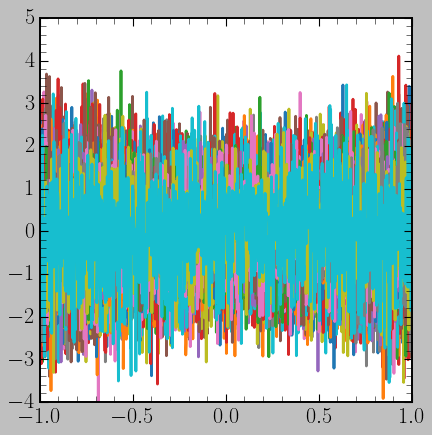

In [65]:
sim = Gaussian(1000, 2)
for i in range(100):
    plt.plot(sim.x, sim.sample()['x'])

In [66]:
database = sim.sample(10000)

100%|██████████| 10000/10000 [00:00<00:00, 27987.29it/s]


In [69]:
gradients = []
for i in range(10000):
    gradients.append(sim.get_gradient(database['z'][i]))
gradients = np.array(gradients)
print(gradients.shape)

(10000, 2, 1000)


In [5]:
sigmas = np.std(database['x'], axis=0)

100%|██████████| 1000/1000 [00:00<00:00, 107033.05it/s]


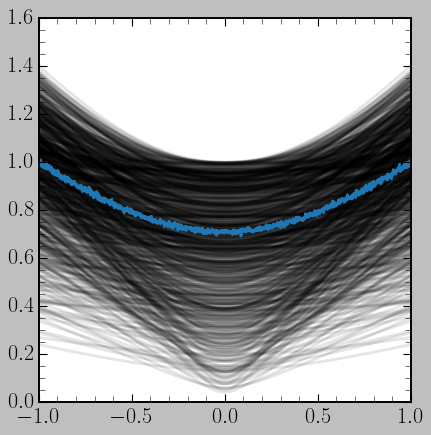

In [6]:
z_sample = sim.sample(1000, targets=['z'])
for i in range(1000):
    z = z_sample['z'][i]
    plt.plot(sim.x, np.sqrt(z[0] * sim.x**2 + z[1]), c='k', alpha=0.1)
plt.plot(sim.x, sigmas)

In [79]:
from typing import Any
from swyft.networks import OnlineStandardizingLayer


class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, est_sigmas, est_gradients, sim):
        super().__init__()
        self.sigmas = est_sigmas
        self.gradients = est_gradients
        self.sim = sim
        self.learning_rate = 1e-3
        self.fc1 = nn.Linear(sim.nbins, sim.nparams)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            num_features=sim.nparams, num_params=sim.nparams, varnames="z"
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            sim.nparams, marginals=((0, 1),), varnames="z"
        )
        self.nl1 = OnlineStandardizingLayer(shape=(sim.nbins,))
        self.nl2 = OnlineStandardizingLayer(shape=(sim.nparams,))
        self.sequential = nn.Sequential(
            nn.Linear(sim.nbins, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, sim.nparams),
        )
        self.sigma = nn.Sequential(
            nn.Linear(sim.nbins, sim.nparams),
            nn.ReLU(),
            nn.Linear(sim.nparams, sim.nparams),
            nn.ReLU(),
            nn.Linear(sim.nparams, sim.nbins),
        )
        self.sigma_gradient = nn.Sequential(
            nn.Linear(sim.nbins, sim.nparams),
            nn.ReLU(),
            nn.Linear(sim.nparams, sim.nparams),
            nn.ReLU(),
            nn.Linear(sim.nparams, sim.nbins * sim.nparams),
        )

    def forward(self, A, B):
        # score_input = self.nl1(
        #     A["x"] ** 2 / self.sigmas**3 - (1.0 / self.sigmas)
        # )
        # score_compression = self.fc1(score_input)
        # compression = self.sequential(self.nl1(A['x']))
        # sigma_estimate = self.sigma(self.nl1(A['x']**2)).detach()
        sigma_estimate = self.sigmas
        # sigma_gradient = self.sigma_gradient(self.nl1(A['x']**2)).view(-1, self.sim.nparams, self.sim.nbins).detach()
        sigma_gradient = torch.tensor(self.gradients).float()
        score_compression = self.nl2(torch.einsum('jk,...k->...j', sigma_gradient, A["x"] ** 2 / sigma_estimate**2))
        lrs1d = self.lrs1d(score_compression, B["z"])
        lrs2d = self.lrs2d(score_compression, B["z"])
        return lrs1d, lrs2d

In [80]:
trainer = swyft.SwyftTrainer(accelerator='cpu')
dm = swyft.SwyftDataModule(database, batch_size=64)
network = InferenceNetwork(sigmas, np.mean(gradients, axis=0), sim)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [81]:
trainer.fit(network, dm)

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name           | Type                     | Params
------------------------------------------------------------
0 | fc1            | Linear                   | 2.0 K 
1 | lrs1d          | LogRatioEstimator_1dim   | 34.9 K
2 | lrs2d          | LogRatioEstimator_Ndim   | 17.5 K
3 | nl1            | OnlineStandardizingLayer | 0     
4 | nl2            | OnlineStandardizingLayer | 0     
5 | sequential     | Sequential               | 10.1 K
6 | sigma          | Sequential               | 5.0 K 
7 | sigma_gradient | Sequential               | 8.0 K 
-------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 7:  49%|████▉     | 77/157 [00:02<00:02, 31.50it/s, loss=-2.54, v_num=132, val_loss=-2.56] 

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [82]:
observation = sim.sample(conditions={'z': np.array([0.5, 0.5])})
prior_samples = sim.sample(targets = ['z'], N = 100000)

100%|██████████| 100000/100000 [00:00<00:00, 271732.42it/s]


In [83]:
predictions = trainer.infer(network, observation, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 98/98 [00:03<00:00, 27.14it/s]


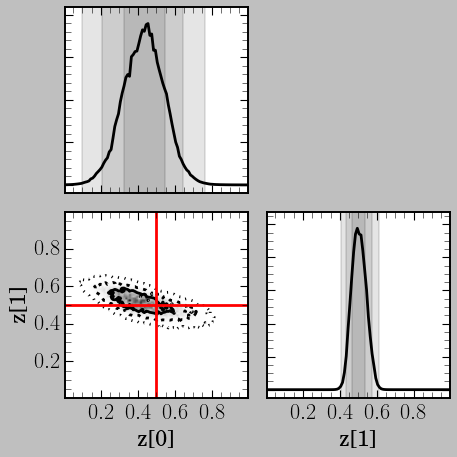

In [84]:
swyft.plot_corner(predictions, parnames = ['z[0]', 'z[1]']);
ax = plt.subplot(2, 2, 3)
ax.axvline(observation['z'][0], color='r')
ax.axhline(observation['z'][1], color='r')

In [66]:
new_bounds = swyft.collect_rect_bounds(predictions[0], 'z', (2,), threshold = 1e-6)
new_bounds

tensor([[4.3618e-06, 9.9999e-01],
        [1.6080e-01, 9.9999e-01]])

100%|██████████| 10000/10000 [00:00<00:00, 33623.05it/s]


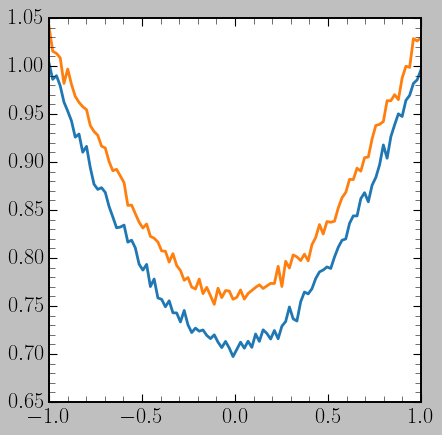

In [76]:
new_sim = Gaussian(100, 2, new_bounds)
database = new_sim.sample(10000)
new_sigmas = np.std(database['x'], axis=0)
plt.plot(sim.x, sigmas)
plt.plot(sim.x, new_sigmas)